LSTM treinadas no conjunto ASSIN
====

Experimentos para treinar redes para a tarefa de RTE no conjunto ASSIN.

Configurações

In [56]:
%matplotlib inline
from __future__ import unicode_literals
from __future__ import division

embedding_file = '../data/embeddings.npy'
vocabulary_file = '../data/vocabulary.txt'
train_file = '../data/assin-ptbr-train.xml'
dev_file = '../data/assin-ptbr-dev.xml'

TODO
====

- Codificar de alguma forma quantidades. No modelo atual, embeddings mapeiam todos os dígitos para 9, de modo a se perder informações numéricas.

Leitura dos dados e das embeddings
------

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:
from collections import defaultdict

import utils

def load_dictionary(filename):
    """
    Load a vocabulary file and create a dictionary.
    
    The rare or unknown symbol is taken to be the first in the list
    """
    with open(filename, 'rb') as f:
        text = unicode(f.read(), 'utf-8')
    
    words = text.splitlines()
    mapping = zip(words[1:], range(1, len(words)))
    
    return defaultdict(int, mapping)



Funções auxiliares
----------


In [152]:
import nltk
max_sentence_len = 60

def tokenize_sentence(text, change_quotes=True, change_digits=False):
    '''
    Tokenize the given sentence in Portuguese. The tokenization is done in conformity
    with Universal Treebanks (at least it attempts so).
    
    :param change_quotes: if True, change different kinds of quotation marks to "
    :param change_digits: if True, replaces all digits with 9.
    '''
    if change_digits:
        text = re.sub(r'\d', '9', text)
    
    if change_quotes:
        text = text.replace('“', '"').replace('”', '"')
    
    tokenizer_regexp = ur'''(?ux)
    # the order of the patterns is important!!
    (?:[^\W\d_]\.)+|                  # one letter abbreviations, e.g. E.U.A.
    \d+(?:[.,]\d+)*(?:[.,]\d+)|       # numbers in format 999.999.999,99999
    \.{3,}|                           # ellipsis or sequences of dots
    \w+(?:\.(?!\.|$))?|               # words with numbers (including hours as 12h30), 
                                      # followed by a single dot but not at the end of sentence
    \d+:\d+|                          # time and proportions
    \d+(?:[-\\/]\d+)*|                # dates. 12/03/2012 12-03-2012
    (?:[DSds][Rr][Aa]?)\.|            # common abbreviations such as dr., sr., sra., dra.
    \$|                               # currency sign
    (?:[\#@]\w+])|                    # Hashtags and twitter user names
    -+|                               # any sequence of dashes
    \S                                # any non-space character
    '''
    tokenizer = nltk.tokenize.RegexpTokenizer(tokenizer_regexp)
    
    return tokenizer.tokenize(text)


def join_pairs(pairs, end_symbol):
    """
    Join each pair of arrays in pairs in pairs and return a list of arrays.
    
    Each joined array has end_symbol between the contents of both original 
    arrays.
    """
    new_pairs = []
    for pair in pairs:
        new_pair = np.concatenate([pair[0], [end_symbol], pair[1]])
        new_pairs.append(new_pair)
    
    return new_pairs


def create_batches(pairs, batch_size, padding_symbol, max_length=None):
    """
    Create and return a list of tuples, each containing a batch and an array
    with their actual sizes (without padding). Each batch is a numpy 2d 
    array in the format (max_length, batch_size)
    
    The pairs are first sorted by size, such as to minimize the amount of 
    padding needed.
    
    :param pairs: a list of arrays with token indices
    :param max_length: if not None, batches are padded until they have this
        length
    """
    pairs.sort(key=lambda x: len(x))
    num_batches = int(math.ceil(len(pairs) / batch_size))
    batches = []
    use_fixed_length = max_length is not None
    
    for i in range(num_batches):
        ind_from = i * batch_size
        ind_to = ind_from + batch_size
        pairs_in_this_batch = pairs[ind_from:ind_to]
        sequence_sizes = np.array([len(x) for x in pairs_in_this_batch])
        
        if not use_fixed_length:
            # since the list is sorted by length, the last one is also the largest
            max_length = len(pairs_in_this_batch[-1])
        
        # the first dimension might be smaller than batch_size for the last batch
        shape = (len(pairs_in_this_batch), max_length)
        batch = np.empty(shape, dtype=np.int32)
        
        for j in range(len(pairs_in_this_batch)):
            # pad each array in the batch
            # this for loop seems inneficient, but I couldn't come up
            # with anything better
            
            pair = pairs_in_this_batch[j]
            pad_shape = (0, max_length - len(pair))
            
            # the str call is because of a numpy bug
            batch[j] = np.pad(pair, pad_shape, str('constant'), 
                              constant_values=padding_symbol)
        
        # append it as (max_length, batch_size)
        batches.append((batch.T, sequence_sizes))
    
    return batches


def extract_raw_text(pairs, token_dict=None):
    """
    Tokenize the T and H components of the given pairs, returning a list of tuples.
    
    If token_dict is not None, tokens are converted to their indices in the
    embeddings space.
    """
    result = []
    for pair in pairs:
        tokens_t = tokenize_sentence(pair.t)
        tokens_h = tokenize_sentence(pair.h)
        
        if token_dict is not None:
            f = lambda tokens: np.array([token_dict[t.lower()] for t in tokens])
            
            indices_t = f(tokens_t)
            indices_h = f(tokens_h)
            item = (indices_t, indices_h)
        else:
            item = (tokens_t, tokens_h)
        
        result.append(item)
    
    return result



In [177]:
token_dict = load_dictionary(vocabulary_file)

train_pairs = utils.read_xml(train_file)
dev_pairs = utils.read_xml(dev_file)

train_pairs_text = extract_raw_text(train_pairs)
dev_pairs_text = extract_raw_text(dev_pairs)

train_pairs = extract_raw_text(train_pairs, token_dict)
dev_pairs = extract_raw_text(dev_pairs, token_dict)

embeddings = np.load(embedding_file)

# the end symbol is the second to last one. It corresponds to the "left padding"
# in the embeddings model
end_symbol = max(token_dict.values()) - 1
pad_symbol = max(token_dict.values())
train_pairs = join_pairs(train_pairs, end_symbol)
dev_pairs = join_pairs(dev_pairs, end_symbol)

In [153]:
batches = create_batches(train_pairs, 50, pad_symbol, max_sentence_len)

In [178]:
embeddings.shape

(160273, 50)

In [148]:
batches[2].shape

(50, 60)

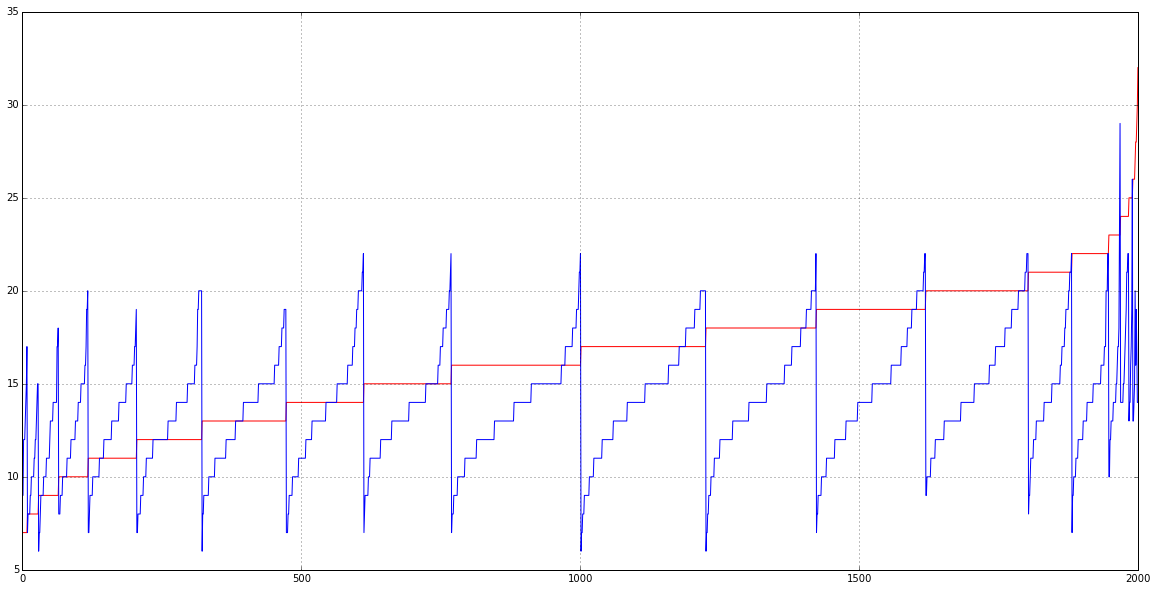

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = (20, 10)

# lexsort picks the indices that sort the arrays following two or more criteria
inds = np.lexsort((lengths_h, lengths_t))
num_items = len(inds)

plt.plot(np.arange(num_items), lengths_t[inds], 'r')
plt.plot(np.arange(num_items), lengths_h[inds], 'b')
plt.grid()
plt.show()

In [29]:
inds = lengths_t.argsort()

In [30]:
lengths_t[inds]

array([ 7,  7,  7, ..., 29, 30, 32])

Modelo
---

A gloriosa LSTM! O primeiro modelo abaixo tenta simular uma versão mais simples da arquitetura usada por Rocktäschel et al. (2015), sem o modelo de atenção. É usada apenas uma LSTM. T e H são dadas como entrada sucessivamente, e um classificador sobre a saída a final da LSTM dá a resposta.

In [221]:
graph = tf.Graph()
embedding_size = 50
num_lstm_units = 128
num_classes = 3


with graph.as_default():
    # input placeholders
    # ==================
    # input_data has shape (sequence_length, batch_size) and each item is a token index
    input_data = tf.placeholder(tf.int32, [max_sentence_len, None], name='token_indices')
    input_labels = tf.placeholder(tf.int32, [None], name='labels')
    
    # the embeddings are a placeholder for pre-initialized values
    tf_embeddings = tf.placeholder(tf.float32, [None, embedding_size])
    
    # we specify the length of each sentence in the batch
    sentence_lengths = tf.placeholder(tf.int32, [None], name='sentence_lengths')
    
    # model parameters
    # ================
    lstm_cell = tf.nn.rnn_cell.LSTMCell(num_lstm_units, embedding_size)
    
    softmax_weights = tf.Variable(tf.truncated_normal([num_lstm_units, num_classes], 0.0, 0.1))
    softmax_bias = tf.Variable(tf.zeros([num_classes]))
    
    # model computations
    # ==================
    input_embeddings = tf.nn.embedding_lookup(tf_embeddings, input_data)
    input_list = [tf.squeeze(time_step) 
                  for time_step in tf.split(0, max_sentence_len, input_embeddings)]
    
    lstm_outputs, state = tf.nn.rnn(lstm_cell, input_list, dtype=tf.float32, sequence_length=sentence_lengths)
    
    # lstm_outputs is (max_seq_len, batch, lstm_size)
    # we only need the last output of each batch item
    lstm_outputs = tf.pack(lstm_outputs, 'lstm_output')
    
    inds = tf.concat(1, [tf.expand_dims(sentence_lengths, 1), tf.expand_dims(tf.range(50), 1)])
    print(inds.get_shape())
    
    last_outputs = tf.slice(lstm_outputs, )
    
    print(lstm_outputs.get_shape())
    print(last_outputs.get_shape())
    
    

(50, 2)


TypeError: Expected list for 'indices' argument to 'DynamicStitch' Op, not Tensor("lstm_output:0", shape=(60, ?, 128), dtype=float32).

Execução
---

Instanciação e execução do grafo

In [217]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.initialize_all_variables())

    batches = create_batches(train_pairs, 50, pad_symbol, max_sentence_len)

    # test with 1 batch
    batch, sequence_lengths_in_batch = batches[0]
    
    feeds = {input_data: batch, sentence_lengths: sequence_lengths_in_batch,
             input_labels: np.arange(10), tf_embeddings: embeddings}
    np_outputs, np_state = sess.run([lstm_outputs, state], feed_dict=feeds)
    np_inds = sess.run([inds], feed_dict=feeds)[0]


In [223]:
np_outputs.shape

(60, 50, 128)